In [1]:
from torchvision import models
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor,Normalize, Resize,ToPILImage
from torch.utils.data import DataLoader
import numpy as np # linear algebra
import pandas as pd # data processing, 
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

import cv2
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
cd /content/drive/My\ Drive/Colab\ Notebooks/

/content/drive/My Drive/Colab Notebooks


### Loading the data

In [0]:
from sklearn.model_selection import train_test_split

    
images = pd.read_pickle('./dataset/input/train/train_images.pkl')
labels = pd.read_csv('./dataset/input/train/train_labels.csv')
test_images = pd.read_pickle('./dataset/input/test/test_images.pkl')

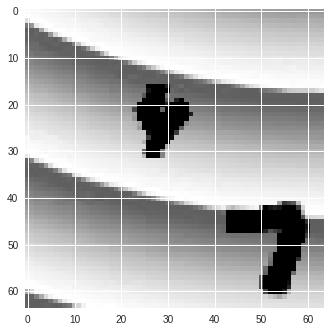

In [4]:
plt.imshow(images[134])
plt.show()

Convert images to RGB

In [0]:
def transform_rgb(img,size):
  img_rs = cv2.resize(img, size, interpolation = cv2.INTER_AREA) 
  img_rgb = np.asarray(np.dstack((img_rs, img_rs, img_rs)), dtype=np.uint8)
  return img_rgb

In [0]:
X = []
for i in range(len(images)):
  X.append(transform_rgb(images[i],(128,128)))
images = np.asarray(X)

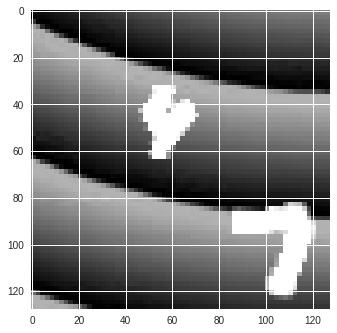

In [7]:
plt.imshow(images[134])
plt.show()

In [0]:
train_images,val_images,train_labels, val_labels = train_test_split(images, labels['Category'][:].values, test_size=0.33, random_state=42)

### Creating the model - VGG16

In [9]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 10)]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
553507836it [00:06, 81162957.76it/s]


1000


### Construct data loaders

In [0]:
from torch.utils.data.dataset import Dataset


class ModMNISTDataset(Dataset):
    def __init__(self,images,labels,transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __getitem__(self, index):
        # stuff
        img = self.images[index]
        
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[index]
            
        return (img, label)

    def __len__(self):
        count = self.images.shape[0]
        return count 

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
        
    data_transform = Compose([ ToPILImage(),
                               Resize((224, 224)),
                               ToTensor(), 
                               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(ModMNISTDataset(train_images,train_labels,data_transform),batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(ModMNISTDataset(val_images,val_labels,data_transform),batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

### Train the model

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_dir = 'models'
TRAIN_FROM_SCRATCH = True

if TRAIN_FROM_SCRATCH:
  model = vgg16.to(device)
  epochs = 30
  TRAIN_FROM_SCRATCH = False

else:
  model_dir = 'models'
  model = vgg16.to(device)
  path = os.path.join(model_dir, 'epoch-vgg-{}.pth'.format(2))
  model.load_state_dict(torch.load(path, map_location=device))
  model = model.to(device)
  epochs = 15
  
start_epoch = 0 # change this to zero for fresh training

start_ts = time.time()
train_loader, val_loader = get_data_loaders(32, 32)

losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(start_epoch,epochs):
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1]
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )        
    
    torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-vgg-{}.pth'.format(epoch)))
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)
print(losses)
print(f"Training time: {time.time()-start_ts}s")

### Evaluation

In [0]:
model.eval()

### Prediction

In [0]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = Variable(data, volatile=True)
            if torch.cuda.is_available():
                data = data.cuda()

            output = model(data)

            pred = output.cpu().data.max(1, keepdim=True)[1]
            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [0]:
test_pred = prediction(test_loader)

In [0]:
out_df = pd.DataFrame(np.c_[np.arange(0, len(X_test))[:,None], test_pred.numpy()], 
                      columns=['Id', 'Category'])

out_df.to_csv('submission.csv', index=False)

In [0]:
from google.colab import files
files.download('submission.csv')